In [1]:
from src import data_loader as dl
from src.models import ExactGPModel
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt


/Users/eirikbaekkelund/opt/anaconda3/envs/gp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocessing Steps

In [22]:
df_location = dl.load_data('pv_data', 'system_location.csv')
df_pv = dl.load_data('pv_data', 'pv.netcdf')

==> Loading data
==> Loaded data in: 0 m : 0 sec

==> Loading data
==> Loaded data in: 19 m : 13 sec



In [3]:
# Set the parameters for data preprocessing
THRESHOLD = 0.05
DAY_MIN = 8
DAY_MAX = 16

In [25]:
df_location = dl.set_index(df_location)

# align pv systems to locations from metadata and the pv data
df_location, df_pv = dl.align_pv_systems(df_location=df_location, 
                                         df_pv=df_pv)

# scale by capacity
df_pv = dl.scale_by_capacity(df_pv, df_location)

# drop systems producing over night
df_pv = dl.drop_night_production(df_pv=df_pv,
                                 threshold=THRESHOLD)

# get daily production from 8am to 4pm
df_pv = dl.daily_production(df_pv=df_pv,
                            day_min=DAY_MIN,
                            day_max=DAY_MAX)

# remove systems with zero production for more than 5 percent of the time
df_pv = dl.remove_zero_production(df_pv=df_pv,
                                  thresh=THRESHOLD)


Dropping 54 systems producing over night


In [26]:
datetime = df_pv.index
df_pv = df_pv.reset_index(drop=True)

df_location, df_pv = dl.align_pv_systems(df_pv=df_pv,
                                         df_location=df_location)
df_pv['datetime'] = datetime

In [27]:
dl.save_csv(df_pv, 'pv_data', 'pv_data_clean.csv')
dl.save_csv(df_location, 'pv_data', 'location_data_clean.csv')

## Example of using preprocessed data

In [4]:
df_pv = dl.load_data('pv_data', 'pv_data_clean.csv')
df_location = dl.load_data('pv_data', 'location_data_clean.csv')

==> Loading data
==> Loaded data in: 0 m : 5 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [4]:
df_location = dl.set_index(df_location)
datetime = df_pv['datetime']

In [2]:
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 10
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_SYSTEMS = 30
RADIUS = 0.3
COORDS = (54.95074, -1.5278)

## Automate process from here to finished data given to GP model

In [3]:
from src.data_loader import DataLoader

In [4]:
loader = DataLoader(n_days=N_DAYS,
                    day_init=9,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv')



==> Loading data
==> Loaded data in: 0 m : 5 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [13]:
time, y = loader.get_time_series()

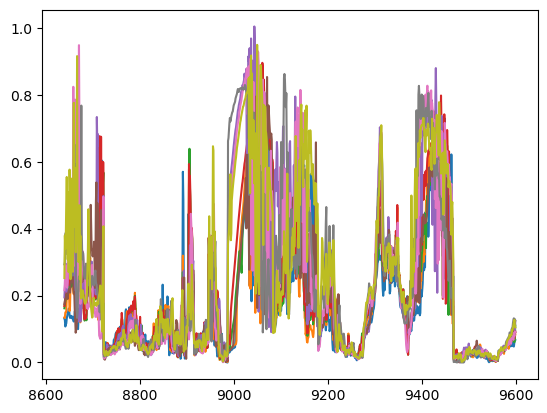

In [14]:
plt.plot(time, y);

# START AUTO

In [624]:
systems = dl.find_nearby_systems(df_location, 
                                     lat=COORDS[0],
                                     lon=COORDS[1],
                                     radius=RADIUS)

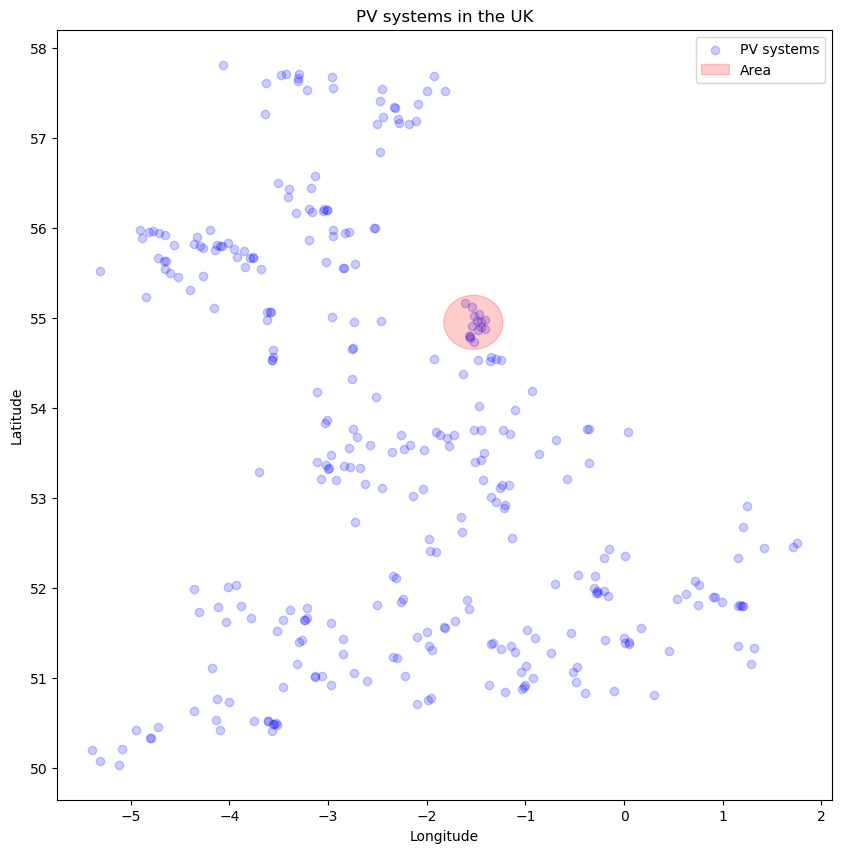

In [625]:
from src.plotting import plot_grid
plot_grid(df_location, COORDS, RADIUS)

In [626]:
N_SAMPLES = int(N_DAYS * DAILY_DATA_POINTS)
T1 = 26
T2 = 1 + T1

In [627]:
systems, pv_systems = dl.align_pv_systems(systems, df_pv)
pv_sample = pv_systems.iloc[N_SAMPLES*T1:T2*N_SAMPLES , :N_SYSTEMS]

In [628]:
lats, longs = dl.get_location_maps(df_location=systems, 
                                   n_systems=N_SYSTEMS)
pv_sample['datetime'] = datetime[N_SAMPLES:2*N_SAMPLES]

In [629]:
pv_stack = dl.stack_dataframe(df_pv=pv_sample,
                                  lats_map=lats,
                                  longs_map=longs)

In [630]:
dl.save_csv(pv_stack, 'pv_data', 'pv_data_stack.csv')

In [656]:
X = pv_stack[['epoch', 'latitude', 'longitude']].values
y = pv_stack['PV'].values

In [657]:
time, r_grid, y = dl.create_spatiotemporal_grid(X, y)
y = y.squeeze()
time = time.squeeze()

In [658]:
def remove_nan_systems(r_grid, y):
    """
    Remove systems that have NaN values
    """
    idx = np.argwhere(np.isnan(y))
    idx = np.unique(idx[:, 1])
    r_grid = np.delete(r_grid, idx, axis=1)
    y = np.delete(y, idx, axis=1)
    
    return r_grid, y

In [659]:
r_grid, y = remove_nan_systems(r_grid, y)

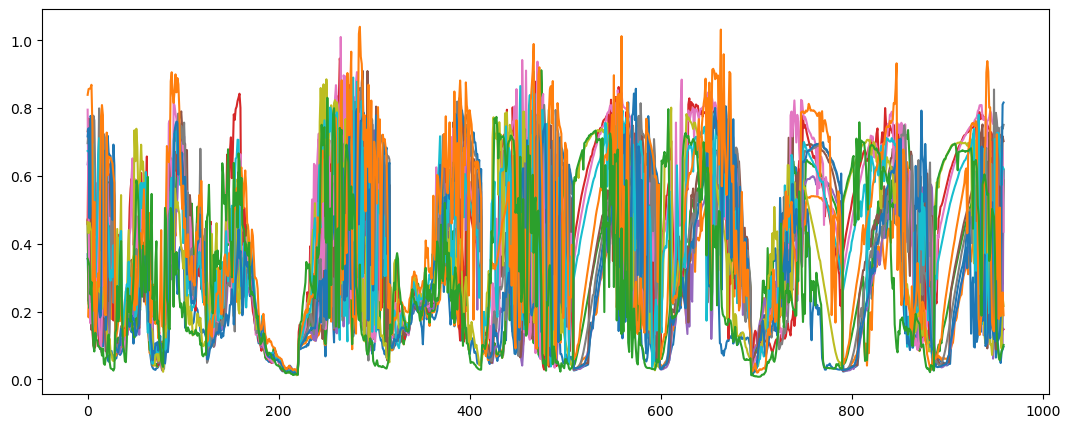

In [660]:
# plot the data
plt.figure(figsize=(13, 5))
plt.plot(y[:,:]);

In [607]:
time_tensor, r_grid, y_tensor = dl.convert_grid_to_tensor(time=time,
                                                          r_grid=r_grid,
                                                          y=y)

# END AUTO

In [47]:
def train_gp(x, y, n_hours, n_iter, lr, optim, likelihood, mean_module, covar_module):
    """
    Train the GP model

    Args:
        train_x (torch.Tensor): training data
        train_y (torch.Tensor): training labels
        n_iter (int): number of iterations
        lr (float): learning rate
        optim (str): optimizer
        mean_module (gpytorch.means.Mean): mean module
        covar_module (gpytorch.kernels.Kernel): covariance module

    Returns:
        ExactGPModel: trained GP model
    """

    
    y_copy = torch.zeros(y.shape)
    y_copy[:, :, 0] = y[:, :, 0]
    
    for k in range(y.shape[1]):
        time, y_sample = dl.extract_time_series(time=x, y=y, idx=k)
        time_train, y_train, time_test, _ = dl.train_test_split_1d(time, y_sample, n_hours=n_hours)
        model = ExactGPModel(time_train, y_train, likelihood, mean_module, covar_module)
        model._train(n_iter, lr, optim)
        preds_test, _ = model.predict(time_test)
        
        y_copy[len(time_train):, k, 0] = preds_test.mean
        
    return y_copy

In [48]:
def create_gp_covars(time, pv_series, index_to_drop, likelihood, mean_module, covar_module):

    # Create the complementary indices to keep
    indices_to_keep = [i for i in range(pv_series.size(1)) if i != index_to_drop]

    # Select the desired time series
    pv_input = torch.index_select(pv_series, dim=1, index=torch.tensor(indices_to_keep))
    pv_pred = train_gp(x=time_tensor,
            y=pv_input,
            n_hours=2,
            n_iter=500,
            lr=0.05,
            optim='Adam',
            likelihood=likelihood,
            mean_module=mean_module,
            covar_module=covar_module)

    covars = torch.cat((time, pv_pred.squeeze()), dim=1)
    target = pv_series[:, index_to_drop, :]

    return covars, target


In [49]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
mean_module = gpytorch.means.ConstantMean()
matern_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=3/2))
periodic_kernel = gpytorch.kernels.PeriodicKernel()

covar_module = matern_kernel  * periodic_kernel

covars, target = create_gp_covars(time_tensor, y_tensor, 8, likelihood, mean_module, covar_module)

Iter 1/500 - Loss: 1.086
Iter 101/500 - Loss: -1.441
Iter 201/500 - Loss: -1.997
Iter 301/500 - Loss: -2.018


KeyboardInterrupt: 

In [137]:
def train_test_split_Nd(X, y, minute_interval=5, n_hours=8):
    """ 
    Splits the data into train and test sets.
    The test set is the last n_hours of the data.

    Args:
        X (torch.tensor): input data
        y (torch.tensor): target data
        minute_interval (int): interval between data points in minutes
        n_hours (int): number of hours to use for test set
    """
    assert X.shape[0] == y.shape[0], 'X and y must have the same number of rows'

    # number of data points in n_hours
    n_points = int(n_hours * 60 / minute_interval)

    # split data into train and test sets
    X_train = X[:-n_points, :]
    y_train = y[:-n_points]
    X_test = X[-n_points:, :]
    y_test = y[-n_points:]

    return X_train, y_train, X_test, y_test

In [138]:
covars, y_train, covars_test, y_test = train_test_split_Nd(covars, target, n_hours=2)

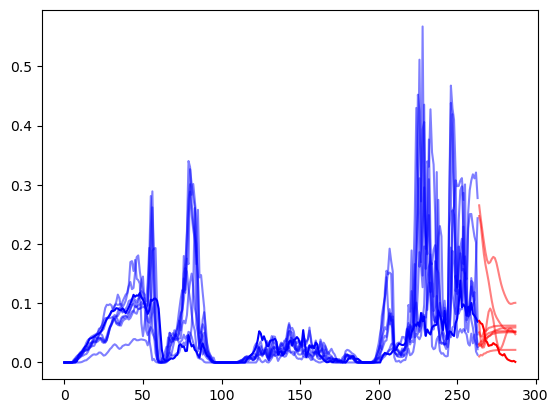

In [142]:
plt.plot(covars[:, 0], covars[:, 1:], color='blue', alpha=0.5, label='covars train');
plt.plot(covars_test[:, 0], covars_test[:, 1:], color='red', alpha=0.5, label='covars test');
plt.plot(covars[:, 0], y_train, color='blue', label='target train');

In [140]:
model = ExactGPModel(train_x=covars,
                     train_y=y_train.squeeze(),
                     likelihood=likelihood,
                     mean_module=mean_module,
                     covar_module=covar_module)

model._train(n_iter=1000, lr=0.05, optim='Adam')

                     

Iter 1/1000 - Loss: 4.198
Iter 101/1000 - Loss: -2.700
Iter 201/1000 - Loss: -3.059
Iter 301/1000 - Loss: -3.097
Iter 401/1000 - Loss: -3.104
Iter 501/1000 - Loss: -3.107
Iter 601/1000 - Loss: -3.108
Iter 701/1000 - Loss: -3.108
Iter 801/1000 - Loss: -3.109
Iter 901/1000 - Loss: -3.109


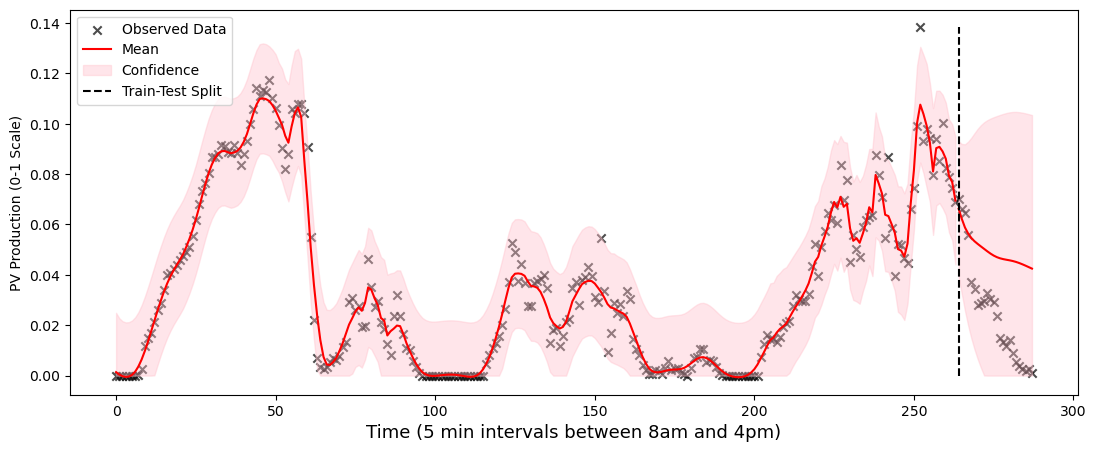

In [141]:
observed_pred, observed_pred_train = model.predict(covars_test)

# plot predictions
plt.figure(figsize=(13, 5))

plt.scatter(covars[:,0], y_train, marker='x', color='black', alpha=0.7, label='Observed Data')
plt.scatter(covars_test[:,0], y_test, marker='x', color='black', alpha=0.7)

plt.plot(covars[:,0], observed_pred_train.mean, color='r', label='Mean')

lower, upper = observed_pred_train.confidence_region()
# clip the lower and upper confidence region to avoid negative values and greater than 1
lower = np.clip(lower, 0, 1)
upper = np.clip(upper, 0, 1)
plt.fill_between(covars[:,0], lower, upper, alpha=0.4, color='pink', label='Confidence')



plt.plot(covars_test[:,0], observed_pred.mean, color='r')
lower, upper = observed_pred.confidence_region()

lower = np.clip(lower, 0, 1)
upper = np.clip(upper, 0, 1)

plt.fill_between(covars_test[:,0], lower, upper, alpha=0.4, color='pink')
plt.vlines(x= len(covars[:,0]), ymin=0, ymax=max(y_train.max(), y_test.max()), 
           color='black', linestyle='--', label='Train-Test Split')


plt.legend()

plt.xlabel('Time (5 min intervals between 8am and 4pm)', fontsize=13)
plt.ylabel('PV Production (0-1 Scale)')

plt.show();